# Handling Missing Data

## Initialize Environment

Set warnings (otionally)

In [1]:
# Set working directory
setwd("C:/ANALYSIS/Data_Preparation/Missing_Data/")

# Disable displaying wornings on R console
#options(warn = -1)

Specify required packages.

In [2]:
required_packages <- c(
  'reshape2',    # Flexibly restructure and aggregate data
  'tidyverse',     # Data science packages collection
  'pastecs',       # Descriptive statistics
  'dplyr',         # Data manipulation
  'scales',        # Scale formatting
  'ggplot2',       # Plotting
  'wesanderson',   # Color palettes
  'gridExtra',     # Plotting
  'VIM',           # Missing data visualization
  'naniar',        # Missing data visualization
  'BaylorEdPsych', # Little's test fro MCAR missingness mechnism
  'mice',          # Multiple imputation
  'randomForest'   # Random forest modeling
)
print(required_packages)

 [1] "reshape2"      "tidyverse"     "pastecs"       "dplyr"        
 [5] "scales"        "ggplot2"       "wesanderson"   "gridExtra"    
 [9] "VIM"           "naniar"        "BaylorEdPsych" "mice"         
[13] "randomForest" 


Load required packages (install missing packages if not already installed). 

In [6]:
#for (c in required_packages) require(c, character.only = TRUE)
for (package in required_packages){ 
  if (!require(package, character.only = TRUE, quietly = TRUE)) {
    install.packages(package, repos='http://cran.us.r-project.org', dependencies = FALSE)
    library(package, character.only = TRUE)
  }
};

## Load Data: 'Boston House Prices'
__Features:__
- __Crime__: per capita crime rate by town
- __Land__: proportion of residential land zoned
- __Business__: proportion of non-retail business acres per town.
- __River__: closeness to river bank.
- __NOx__: nitrogen oxides concentration.
- __Rooms__: average number of rooms per dwelling.
- __Age__: proportion of owner-occupied units built prior to 1940.
- __Distance__: weighted mean of distances to five Boston employment centres.
- __Highway__: index of accessibility to radial highways.
- __Tax__: full-value property-tax rate per 10.000 dollar.
- __Teachers__: pupil-teacher ratio by town.
- __Blacks__: the proportion of blacks by town.
- __Population__: lower status of the population (percent)
- __Value__ (response feature): median value of owner-occupied homes in $1000s.

In [77]:
# Original complete data set
df <- readRDS("data/Boston_Original.rds")
cat ("Size of data set:", dim(df)[1], "cases and", dim(df)[2], "features.")

Size of data set: 506 cases and 14 features.

In [78]:
head(df)

Crime,Land,Business,River,NOx,Rooms,Age,Distance,Highway,Tax,Teachers,Blacks,Population,Value
0.00632,18,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
0.02731,0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
0.02729,0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
0.03237,0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
0.06905,0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
0.02985,0,2.18,0,0.458,6.430,58.7,6.0622,3,222,18.7,394.12,5.21,28.7


In [79]:
# Incomplete (amputed) data set
mdf <- readRDS("data/Boston_MissingGeneratedByMICEAmputation_Uncoded.rds")
cat ("Size of data set:", dim(mdf)[1], "cases and", dim(mdf)[2], "features.")

Size of data set: 506 cases and 14 features.

In [80]:
head(mdf)

Crime,Land,Business,River,NOx,Rooms,Age,Distance,Highway,Tax,Teachers,Blacks,Population,Value
,18,2.31,0,0.538,6.575,65.2,4.09,1,296,15.3,396.9,4.98,24
0.02731,0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.9,9.14,21.6
0.02729,0,7.07,0,---,7.185,61.1,-,2,242,17.8,392.83,4.03,34.7
0.03237,0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
0.06905,0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.9,5.33,36.2
0.02985,0,2.18,0,0.458,6.43,58.7,6.0622,3,222,18.7,394.12,5.21,28.7


## Identify Potentially Missing Values

### Identify data entries, which may represent missing values

In [11]:
# Identify 'empty' data entries, which may intid´cate missing values.
empty_strings <- sort(
                    unique(
                      unlist(
                        unname(
                          lapply(mdf, function(x) x[!grepl("^[[:alpha:]]|^[[:digit:]]", x) | is.na(x)])
                        )
                      )
                    ), na.last = TRUE
                  )
cat ("Data entries potentially representing missing data:", empty_strings)

Data entries potentially representing missing data:  - ---   . _ NA

### Analyze potenitally missing data entries 

In [12]:
# Initilize data frame: Missing-Data-Codings x Features-in-Data-Set
# to count different codings of "empty" cells in the 'mdf' data set
empty_counts <- setNames(data.frame(
  matrix(data = 0, ncol = ncol(mdf), nrow = length(empty_strings)+1)), colnames(mdf))

# Name rows: each row dedicated to one coding of missing values
row_names <- append(empty_strings, "Complete", after = length(empty_strings))
row_names[is.na(row_names)] <- "<NA>"
row_names[row_names == ""] <- "\"\""
row_names[row_names == " "] <- "\" \""

rownames(empty_counts) <-  row_names

# Count missing value codding in the data set
for (i in 1:length(empty_strings)){
  if (!is.na(empty_strings[i]))
    empty_counts[i, ] <- lapply(mdf, function(x) sum(x == empty_strings[i], na.rm = TRUE))
  else
    empty_counts[i, ] <- lapply(mdf, function(x) sum(is.na(x)))
}
                                
# Finally, count the number of complete (non-empty) values per column
empty_counts[length(empty_strings) + 1, ] <- lapply(empty_counts, function(x) nrow(mdf) - sum(x[1:length(empty_strings)]))

# Reorder features according to the amout of complete cases
empty_counts <- empty_counts[,order(-empty_counts[nrow(empty_counts),])]

# Visualize missing ('empty') data values
long_empty_counts <- melt(as.matrix(empty_counts))

### Visualize portions of potentially missing data

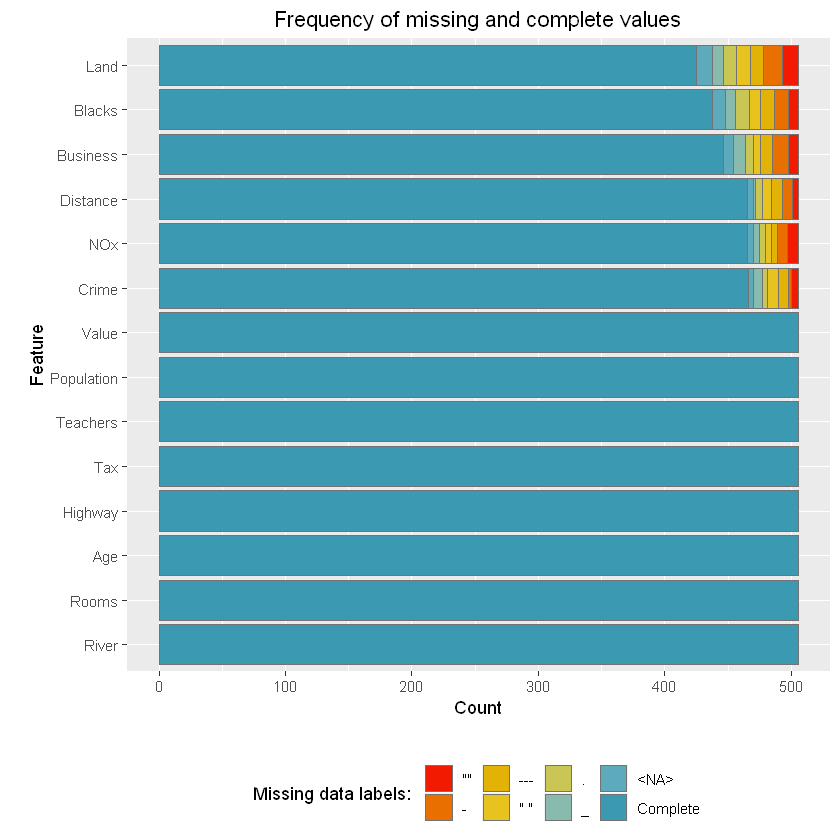

In [13]:
ggplot(data = long_empty_counts) +
  geom_bar(aes_string(x = "Var2", y = "value", fill = "Var1"), colour="#737373", stat = "identity") +
  ggtitle("Frequency of missing and complete values") +
  xlab("\nFeature") +
  ylab("Count\n") +
  coord_flip() +
  scale_fill_manual(values = rev(wes_palette("Zissou1", n = nrow(empty_counts), type = "continuous")), name = "Missing data labels: ") +
  theme(legend.position = "bottom", plot.title = element_text(hjust = 0.5))

## Code missing values consistently

In [14]:
# Code missing data using 'NA'
mdf <- as.data.frame(lapply(mdf, function(x) gsub(x = x, pattern = "^[^[:alpha:][:digit:]]*$", 
                                                  replacement = NA, perl = TRUE)), 
                     stringsAsFactors = FALSE)
# Set data types of features
mdf <- data.frame(lapply(mdf, as.numeric))

## Analyze Volume and Pattern of Missing Data

### Compute total amount of missing values.

In [15]:
# Function to compute total count of missing cells in a data frame
missing_count_total <- function (df){
  return(sum(is.na(df)))
}
# Function to compute total ratio of missing cells in a data frame 
missing_portion_total <- function (df){
  portion <- (sum(is.na(df)) / (nrow(df) * ncol(df)))
  return(round(portion, digits = 2))
}

In [16]:
cat("Valume of missing data: \n",
    "Total count of missing data:", missing_count_total(mdf), "\n", 
    "Total percentage of missing data:", missing_portion_total(mdf) * 100, "%")

Valume of missing data: 
 Total count of missing data: 331 
 Total percentage of missing data: 5 %

### Compute portions of missing data per feature.

In [17]:
# Function to cout missing values per data frame column
missing_portion_per_feature <- function (df){
  propNA <- sapply(df,function(x) round((sum(is.na(x)) / length(x)) * 100, digits = 2))
  propNA <- setNames(as.data.frame(propNA), c("Missing_Ratio"))
  pNA <- data.frame ("Attribute" = rownames(propNA))
  pNA$Missing_Ratio <- propNA$Missing_Ratio
  pNA <- pNA[with(pNA, order(-Missing_Ratio)), ]
  colnames(pNA) <- c("Feature", "Missing %")
  
  return(pNA)
}

In [18]:
missing_portion_per_feature(mdf)

,Feature,Missing %
2,Land,16.01
12,Blacks,13.44
3,Business,11.86
5,NOx,8.10
8,Distance,8.10
1,Crime,7.91
4,River,0.00
6,Rooms,0.00
7,Age,0.00
9,Highway,0.00


### Analyze and visualize missing data pattern

In [19]:
## Prepare summary matrix of missing and observed values
missing_values <- mdf %>%
  gather(key = "key", value = "val") %>%
  mutate(isna = is.na(val)) %>%
  group_by(key) %>%
  mutate(total = n()) %>%
  group_by(key, total, isna) %>%
  summarise(missing_count = n()) %>%
  mutate(missing_ratio = missing_count / total)

## Sort featues according to the amount of missing values
levels <- (missing_values  %>% 
             #filter(isna == TRUE) %>%     
             arrange(desc(missing_ratio)))$key %>%
          unique()

#### Create plot for missing data portions using bar chart.

In [20]:
missing_percentage_plot <- missing_values %>%
  ggplot(aes(x = reorder(key, desc(missing_ratio)), 
             y = missing_ratio, fill = isna, label = paste0(round(missing_ratio * 100, 1), "%"))) +
  geom_bar(stat = 'identity', alpha = 0.8) +
  geom_text(size = 3, position = position_stack(vjust = 0.5)) +
  scale_x_discrete(limits = levels) +
  scale_y_continuous(labels = percent) +
  scale_fill_manual(name = "", 
                    values = c('steelblue', 'tomato3'), 
                    labels = c("Present", "Missing")) +
  labs(title = "Percentage of missing values", 
       x = 'Feature', y = "% of missing values") +
  theme(legend.position = "bottom") +
  coord_flip()
#missing_percentage_plot

#### Create plot for missing values patterns.

In [21]:
missing_pattern_plot <- mdf %>%
  mutate(id = row_number()) %>%
  gather(-id, key = "key", value = "val") %>%
  mutate(isna = is.na(val)) %>%
  ggplot(aes(x = key, y = id, fill = isna)) +
  geom_raster(alpha=0.8) +
  scale_fill_manual(name = "",
                    values = c('steelblue', 'tomato3'),
                    labels = c("Present", "Missing")) +
  scale_x_discrete(limits = levels) +
  labs(x = "Feature",
       y = "Case", title = "Missing values pattern") +
  theme(legend.position = "bottom") +
  coord_flip()
#missing_pattern_plot

#### Combine missing data portions and patterrn plots.

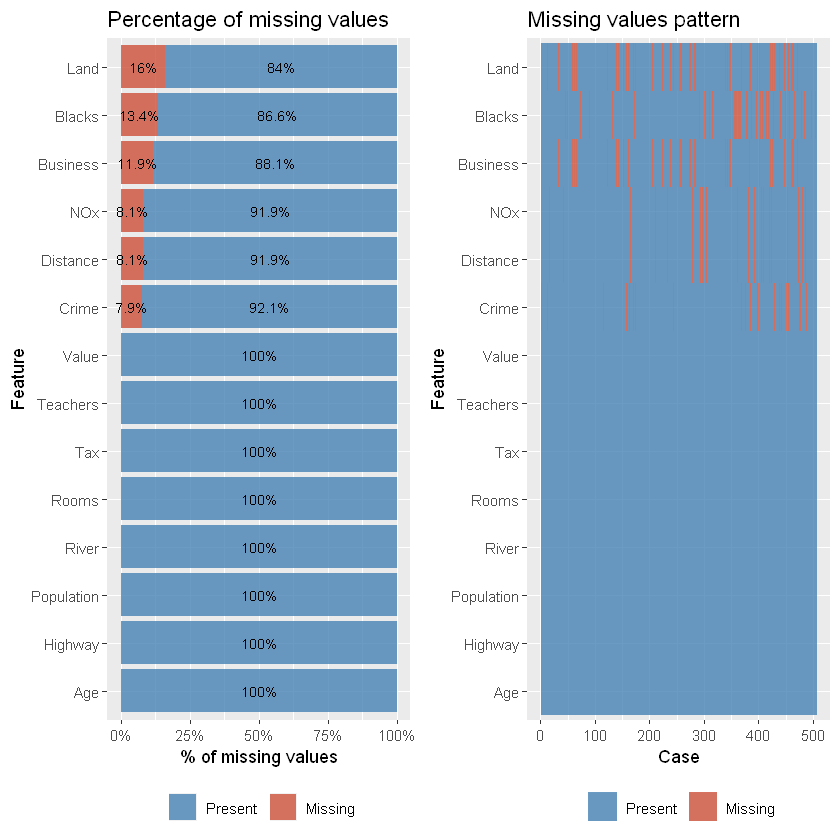

In [22]:
grid.arrange(missing_percentage_plot, missing_pattern_plot, ncol = 2)

### Visualize missingness pattern using 'VIM' package.

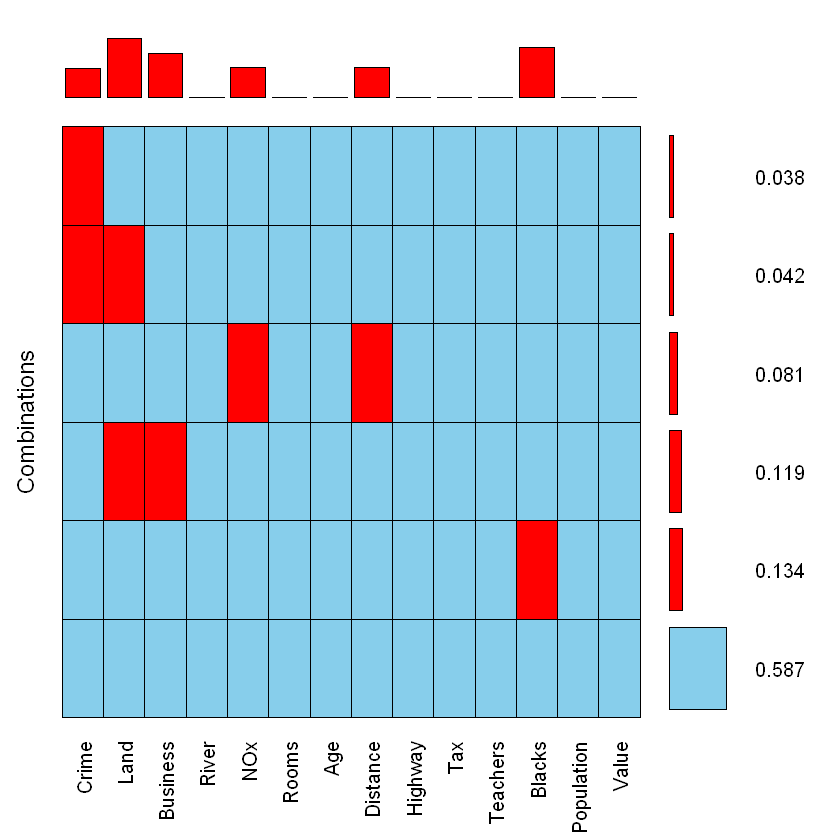

In [23]:
aggr(mdf, combined = TRUE, numbers = TRUE)

### Visualize combinations of missingness across cases using 'naniar' package.
Analysis of relationships between sets (case-wise) of missing data on features. 

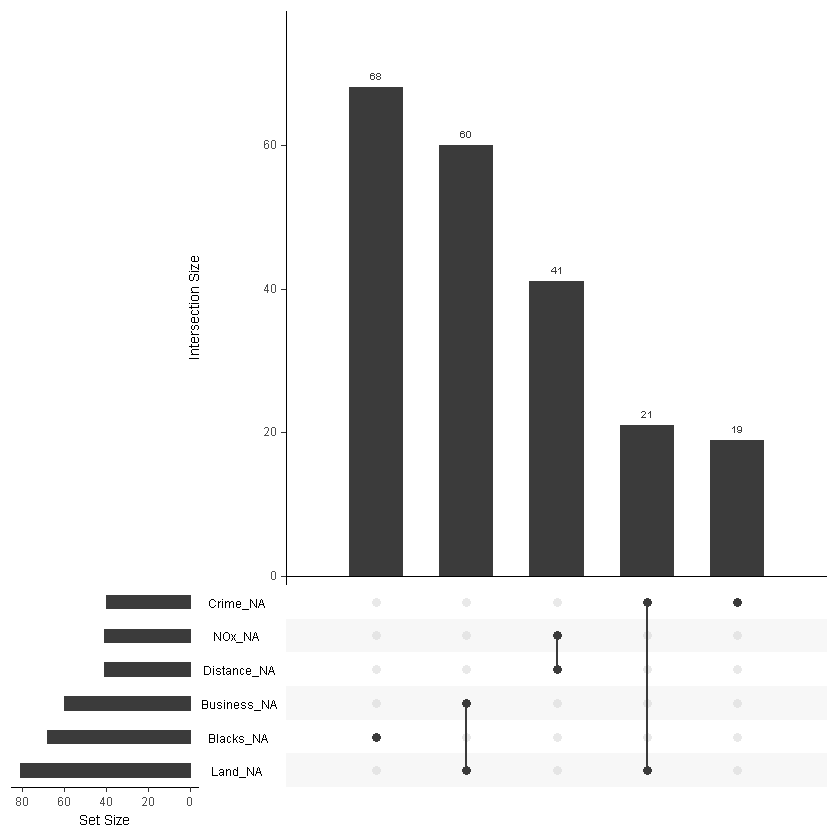

In [24]:
gg_miss_upset(mdf, nsets = n_var_miss(mdf))

__Example interpretation__: 'Land' has the most missing values. There are 60 cases where both 'Business' and 'Land' have missing values together. 

## Analyze Missingness Mechanism
- __Missing completely at random (MCAR):__ probability of missing data on a feature Y is unrelated to any other features and is unrelated to the values of Y itself.
- __Missing at random (MAR):__ the probability of missing data on a feature Y is related to some other measured features in the data but not to the values of Y itself.
- __Missing not at random (MNAR):__ probability of missing data on a feature Y is related to the values of Y itself.

<font color=red>Warning:</font> Missingness mechanism cannot be determined definitively because missing values are not known. Existing analysis methods may only give an indication of probable mechanism.

### Draw density plots for missing data.
Does distribution of missing data on a feature correlate with complete values of other features (MAR vs. MCAR)?

<font color=blue>Question:</font> Is missing data for 'Crime rate' related to the whether the data refer to business or habitat areas of Boston?

Warning message:
"Removed 60 rows containing non-finite values (stat_density)."

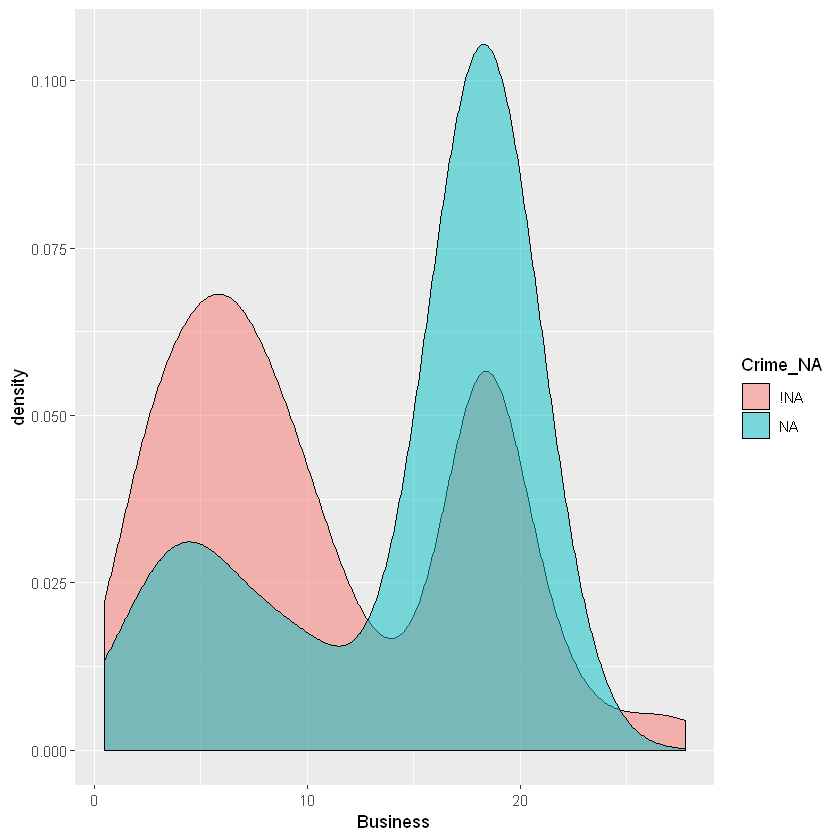

In [25]:
mdf %>%
  bind_shadow() %>%
  ggplot(aes(x = Business, fill = Crime_NA)) + 
  geom_density(alpha = 0.5)

<font color=blue>Question:</font> Is missing data for 'Crime rate' related to how old are areas (buildings) of Boston?

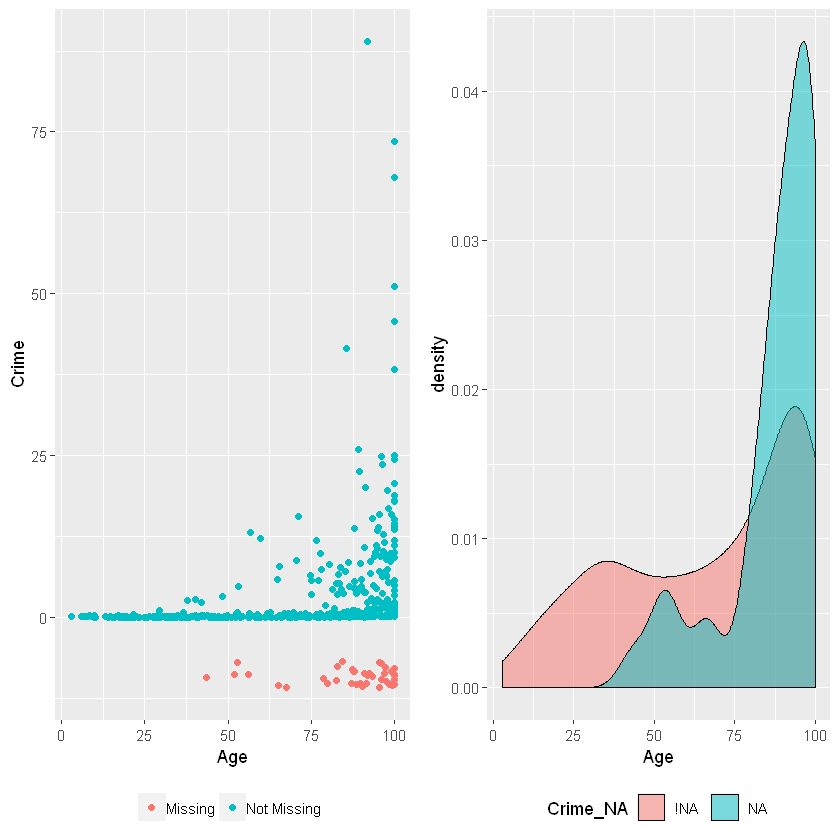

In [26]:
scatter <- ggplot(data = mdf, aes_string(x = "Age", y = "Crime")) +
  geom_miss_point() +
  theme(legend.position = "bottom", legend.title = element_blank())

density <- mdf %>%
  bind_shadow() %>%
  ggplot(aes(x = Age, fill = Crime_NA)) + 
  geom_density(alpha = 0.5) +
  theme(legend.position = "bottom")

grid.arrange(scatter, density, ncol = 2)

### Statistical test of missingess (Little's Test)
Little's Chi-Square test for MCAR.
Null hypothesis (H0): Data is MCAR.
IF p < 0.05 THEN H0 can be rejected (data is not MCAR).

In [28]:
#options (warn = -1)
features <- c('Age', 'Business', 'Crime')
little_test <- LittleMCAR(mdf[, features])
little_test_outome <- ifelse (little_test$p.value < 0.05, "not MCAR", "MCAR")
cat(
  "\nLittle test results for the following features:", paste(features, collapse = ', '), "\n",
  "Number of missing patterns:", little_test$missing.patterns, "\n",
  "Statistic value (chi):", round(little_test$chi.square, 1), "\n",
  "Significance level (p): ", little_test$p.value, "\n",
  "Conclusion: The data is", little_test_outome)
#options (warn = 1)

this could take a while
Little test results for the following features: Age, Business, Crime 
 Number of missing patterns: 3 
 Statistic value (chi): 24.1 
 Significance level (p):  7.745135e-05 
 Conclusion: The data is not MCAR

## Handle Missing Data
__Analyze outcomes for example features: Distance, NOx__

Define usefull functions.

In [51]:
# Compute basic statistics for numeric vectors
get_stats <- function (num_vec, header){
  stats <- data.frame(Stats = c('Min', 'Max', 'Mean', 'Median', 'StDev'),
                      Value = c(min(num_vec), 
                               max(num_vec), 
                               mean(num_vec), 
                               median(num_vec), 
                               sd(num_vec))
                      )
  colnames(stats)[2] <- header
  stats[, header] <- round(stats[, header], 2)
  return(stats)
}

# Create violin plot to visualize distribution of complete and missing/imputed data
plot_violin <- function (df, ind_var, grp_var, title){
  ## Generate color palette for unique values of grp-var indicating imputations
  ## First color is blue and the remaining a"re random variations of red
  base_palette <- c("coral1", "chocolate2", "brown2", "deeppink2", "darkorange1", "darkorchid1", 
                    "goldenrod2", "firebrick2", "maroon2", "magenta2", "orangered2", "red3", "violetred2", "tomato2")
  cust_colors <- c("deepskyblue3", colorRampPalette(base_palette)(length(unique(df[, grp_var]))-1))
  
  plt <- ggplot(df, aes_string(x = 1, y = ind_var, colour = grp_var)) +
         geom_violin(colour = "grey60", fill = "grey90") +
         geom_point (size = 3, position = position_jitter(width = 0.2, height = 0.2), alpha = 0.3) +
         scale_color_manual(values=cust_colors) +
         ggtitle(title) + labs (color = "Imputed") +
         theme(panel.background = element_rect(fill = "grey95", colour = "grey60"), 
               axis.title.x=element_blank(), axis.text.x=element_blank(),
               axis.ticks.x=element_blank(), legend.position = "bottom",
               plot.title = element_text(hjust = 0.5))
  return(plt)
}

Create reference plot of complete data

In [52]:
# Derive table with logical indicators of missing values (it is required by scattMiss plotting)
mdfm <- as.data.frame(is.na(mdf))
colnames(mdfm) <- paste(colnames(mdf), "imp", sep = "_")

# Select example feature to visualize
ind_var <- "Distance"
grp_var <- "Distance_imp"

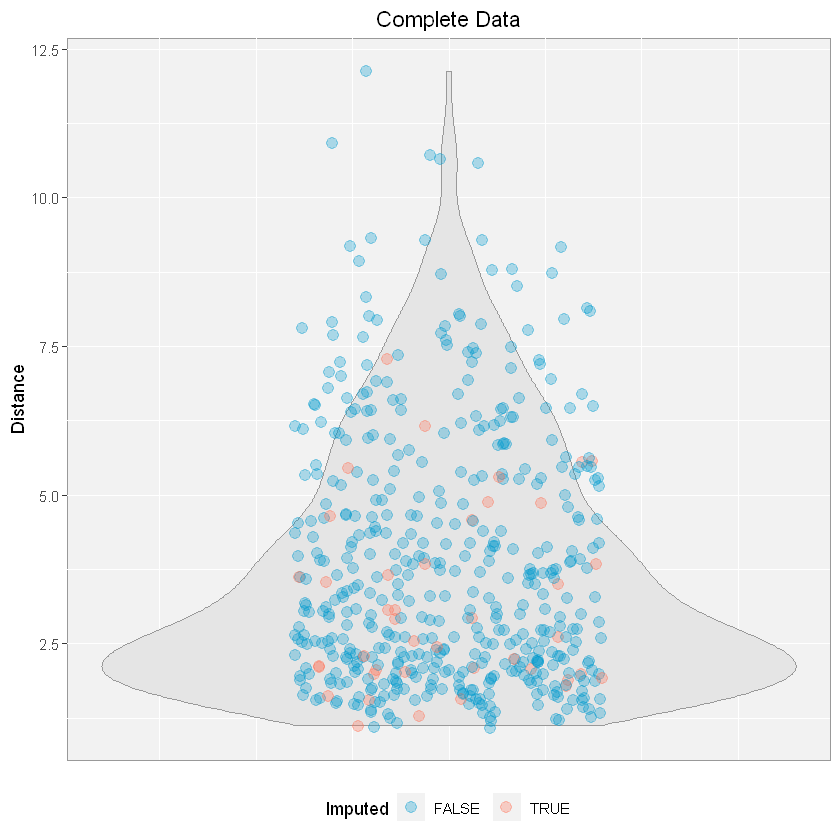

In [53]:
# Prepare data: add to data information about missing 
df_md <- df
df_md[, grp_var] <- mdfm[, grp_var]

# Plot complete data and highlight imputed (previously) missing data points
df_plt <- plot_violin(df_md, ind_var, grp_var, "Complete Data")
df_plt

In [54]:
df_stats <- get_stats(df[,ind_var], "Original")
df_stats

Stats,Original
Min,1.13
Max,12.13
Mean,3.80
Median,3.21
StDev,2.11


### Listwise delection
Cases where value on at least one feature is missing are removed from the data set.

In [55]:
lwd_df <- mdf[complete.cases(mdf), ]

cat("Data reduction due to list-wise deletion:\n",
    "Number of cases before:", nrow(mdf), "\n",
    "Number of cases after:", nrow(lwd_df), "\n", 
    "Reduction of cases by:", round(nrow(lwd_df) / nrow(mdf) * 100, 1), "%")

Data reduction due to list-wise deletion:
 Number of cases before: 506 
 Number of cases after: 297 
 Reduction of cases by: 58.7 %

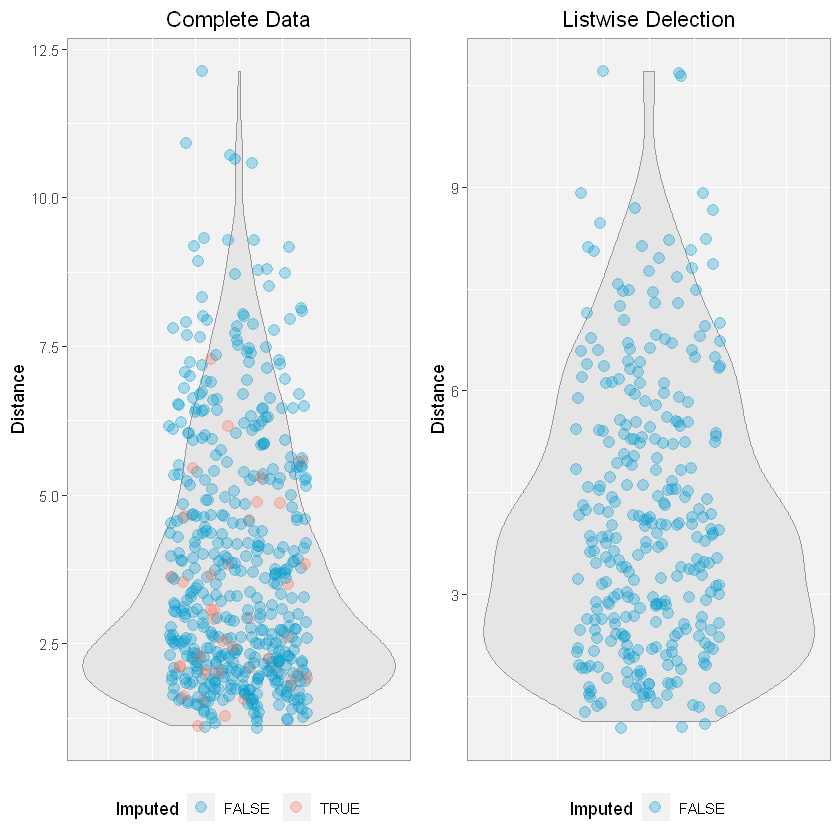

In [82]:
# Prepare data: add to data information about missing 
lwd_df[, grp_var] <- FALSE

# Plot complete data and highlight imputed (previously) missing data points
plt_lwd <- plot_violin(lwd_df, ind_var, grp_var, "Listwise Delection")
grid.arrange(df_plt, plt_lwd, ncol = 2)

In [57]:
lwd_stats <- get_stats(lwd_df[,ind_var], "LWD")
lwd_stats <- cbind(df_stats, lwd_stats["LWD"])
lwd_stats

Stats,Original,LWD
Min,1.13,1.13
Max,12.13,10.71
Mean,3.80,4.15
Median,3.21,3.84
StDev,2.11,2.03


### Mean Imputation
Missing values on a feature are approximated by the mean of complete values on this feature.

In [58]:
mean_imp_df <- as.data.frame(
  lapply(mdf, function(x) replace(x, is.na(x), mean(x, na.rm = TRUE)))) %>% bind_rows()

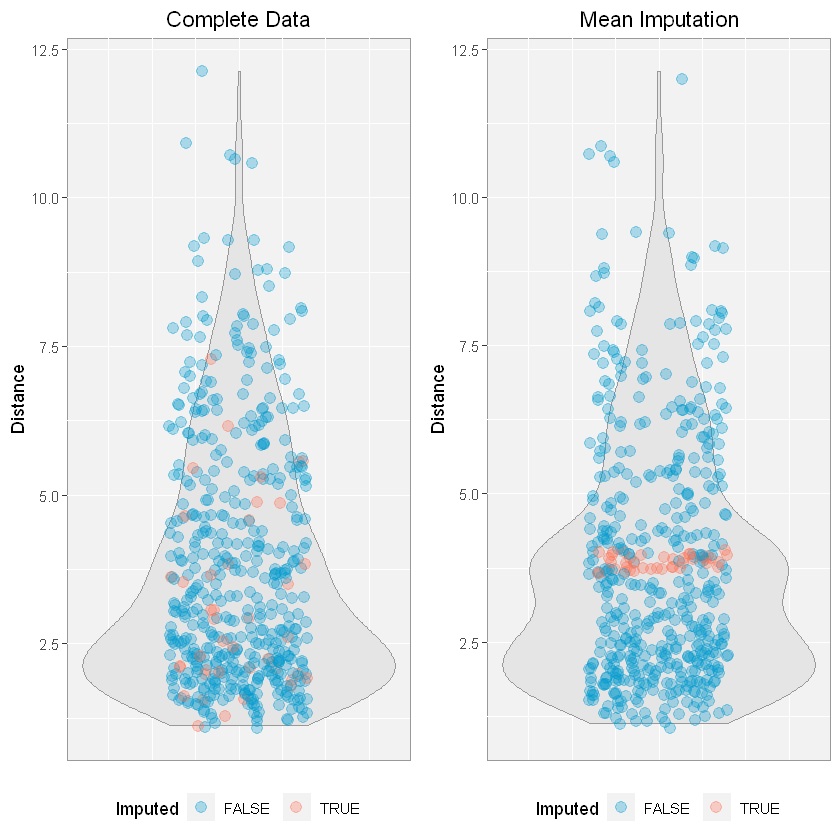

In [83]:
# Prepare data
mean_imp_df[, grp_var] <- mdfm[, grp_var]

# Plot complete data and highlight imputed (previously) missing data points
plt_mean_imp <- plot_violin(mean_imp_df, ind_var, grp_var, "Mean Imputation")
grid.arrange(df_plt, plt_mean_imp, ncol = 2)

In [60]:
mean_stats <- get_stats(mean_imp_df[,ind_var], "Mean_Imp")
mean_stats <- cbind(df_stats, mean_stats["Mean_Imp"])
mean_stats

Stats,Original,Mean_Imp
Min,1.13,1.13
Max,12.13,12.13
Mean,3.80,3.85
Median,3.21,3.54
StDev,2.11,2.05


### Hot-Deck Randomized Imputation
Data set is sorted and missing values are imputed sequentially running through the data set case by case. <br>_A. Kowarik, M. Templ (2016) Imputation with R package VIM. Journal of Statistical Software, 74(7), 1-16._

In [61]:
hdr_imp_df <- VIM::hotdeck(mdf, imp_var = TRUE, imp_suffix = "imp")

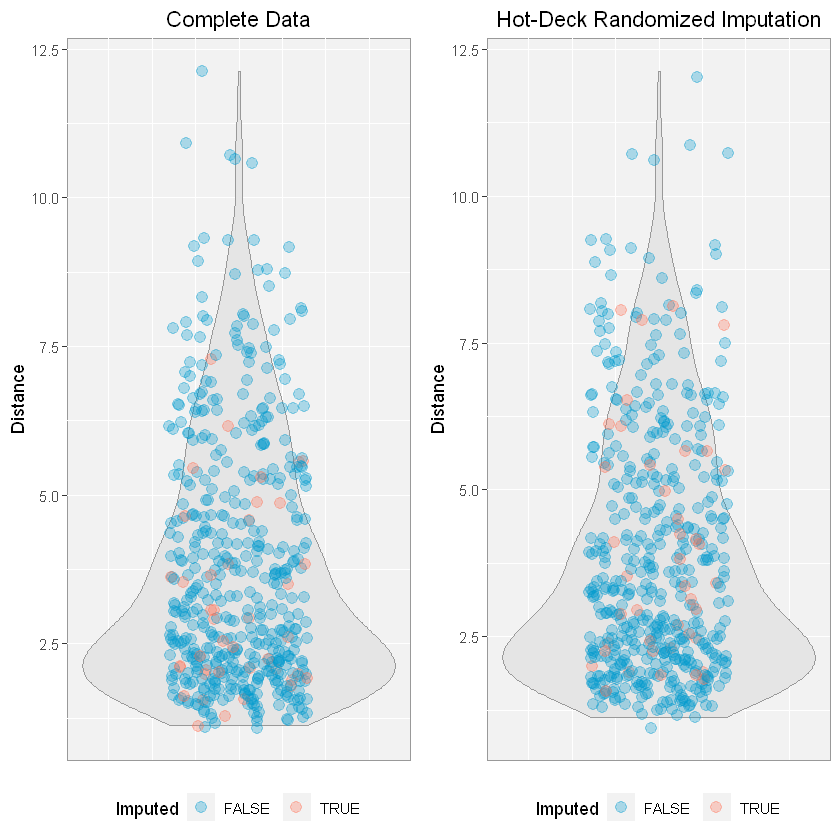

In [84]:
# Plot complete data and highlight imputed (previously) missing data points
plt_hdr_imp <- plot_violin(hdr_imp_df, ind_var, grp_var, "Hot-Deck Randomized Imputation")
grid.arrange(df_plt, plt_hdr_imp, ncol = 2)

In [63]:
hdr_stats <- get_stats(hdr_imp_df[,ind_var], "HDR_Imp")
hdr_stats <- cbind(df_stats, hdr_stats["HDR_Imp"])
hdr_stats

Stats,Original,HDR_Imp
Min,1.13,1.13
Max,12.13,12.13
Mean,3.80,3.86
Median,3.21,3.30
StDev,2.11,2.12


### Hot-deck k-Nearest-Neighbours Imputation
Similar to the hot-deck method, the k nearest neighbor method is based on donor observation. An aggregation of the k values of the nearest neighbors is used as imputed value. <br>_A. Kowarik, M. Templ (2016) Imputation with R package VIM. Journal of Statistical Software, 74(7), 1-16._

In [64]:
knn_imp_df <- VIM::kNN(mdf, imp_var = TRUE, imp_suffix = "imp")

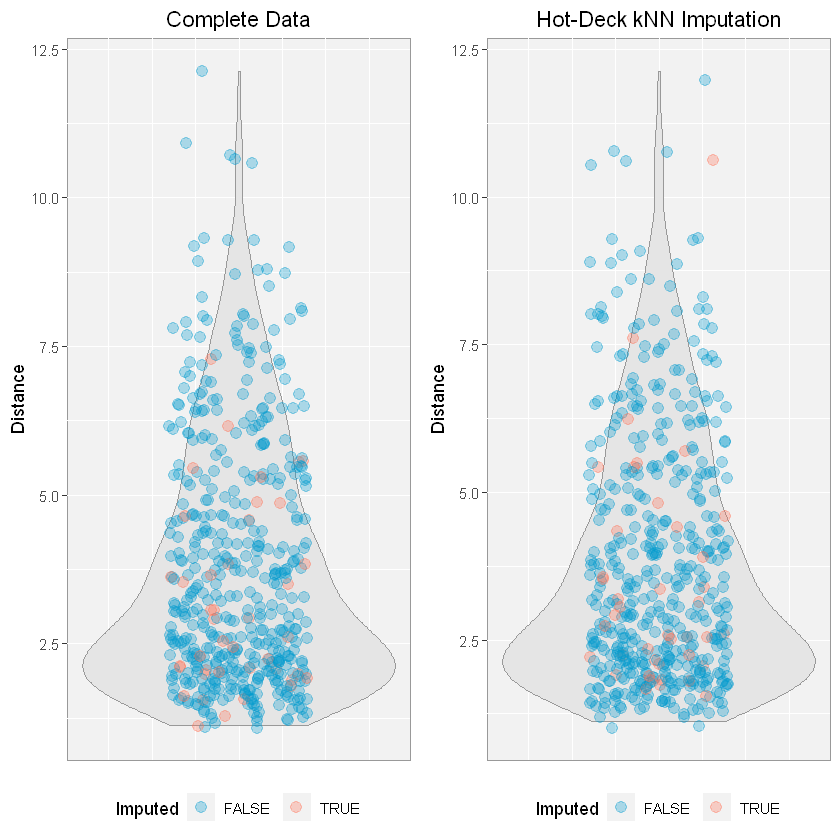

In [85]:
# Plot complete data and highlight imputed (previously) missing data points
plt_knn_imp <- plot_violin(knn_imp_df, ind_var, grp_var, "Hot-Deck kNN Imputation")
grid.arrange(df_plt, plt_knn_imp, ncol = 2)

In [66]:
knn_stats <- get_stats(knn_imp_df[,ind_var], "kNN_Imp")
knn_stats <- cbind(df_stats, knn_stats["kNN_Imp"])
knn_stats

Stats,Original,kNN_Imp
Min,1.13,1.13
Max,12.13,12.13
Mean,3.80,3.82
Median,3.21,3.22
StDev,2.11,2.12


### Regression Imputation
Missing value are imputed per feature, based on a regression model built on complete data. For a feature y a linear regression model is first fitted using one or more complete features X. Missing values on y are then estimated using the  regression model. <br>_A. Kowarik, M. Templ (2016) Imputation with R package VIM. Journal of Statistical Software, 74(7), 1-16._

In [67]:
## Identify complete and incomplete features
incomplete_features <- colnames(mdf)[colSums(is.na(mdf)) > 0]
complete_features <- colnames(mdf)[colSums(is.na(mdf)) == 0]

## Create regression formula: y: incomplete features, x: compelte features
regr_formula <- as.formula(paste0(
  paste(incomplete_features, collapse = "+"), " ~ ", paste(complete_features, collapse = "+")))

## Run imputation: returns only the imputed incomplete features
reg_imp_df <- VIM::regressionImp(data = mdf, formula = regr_formula, imp_var = TRUE, imp_suffix = "imp")

## Add complete features to get complete data set (all original features)
reg_imp_df <- cbind(reg_imp_df, df_md[!names(df_md) %in% names(reg_imp_df)])

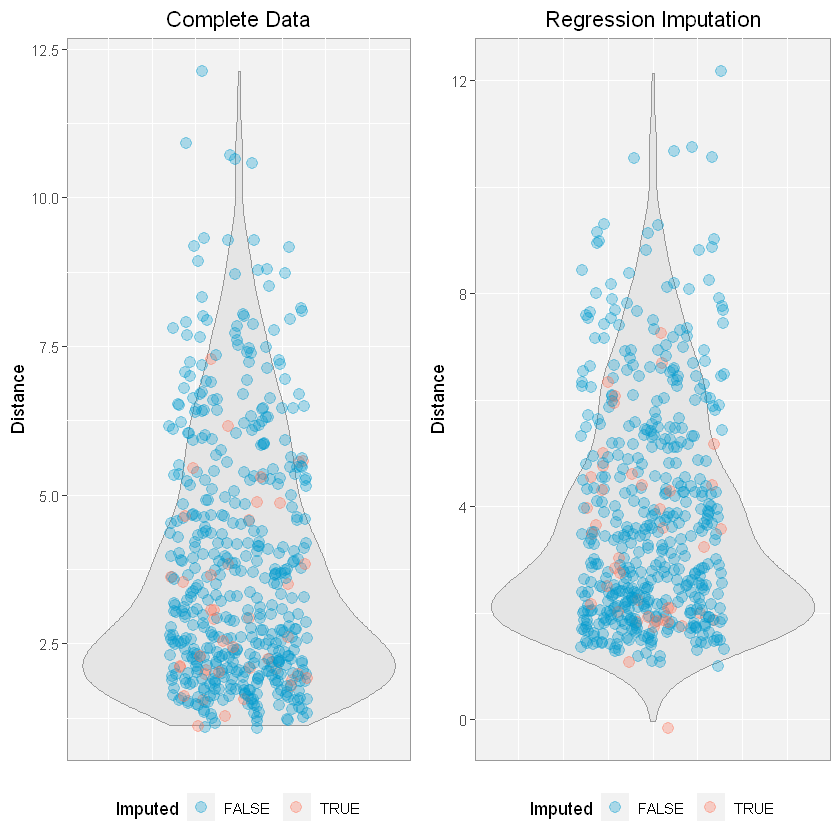

In [86]:
# Plot complete data and highlight imputed (previously) missing data points
plt_reg_imp <- plot_violin(reg_imp_df, ind_var, grp_var, "Regression Imputation")
grid.arrange(df_plt, plt_reg_imp, ncol = 2)

In [69]:
reg_stats <- get_stats(reg_imp_df[,ind_var], "Reg_Imp")
reg_stats <- cbind(df_stats, reg_stats["Reg_Imp"])
reg_stats

Stats,Original,Reg_Imp
Min,1.13,-0.04
Max,12.13,12.13
Mean,3.80,3.81
Median,3.21,3.27
StDev,2.11,2.11


### Multiple Imputation with Random Forrest
Multiple complete data sets genegrated for an incomplete data. In each iteration, the algorithm generates multiple imputations for incomplete multivariate data by Gibbs conditional sampling. The algorithm imputes an incomplete feature (the target feature) using on a model based on other features (in this case the Random Forest model). <BR> _Van Buuren, S., Groothuis-Oudshoorn, K. (2011). mice: Multivariate Imputation by Chained Equations in R. Journal of Statistical Software, 45(3), 1-67._

In [70]:
# Multiple imputation using 'mice' package
mi_df <- mice::mice(data = mdf, m = 4, maxit = 2, printFlag = TRUE, method = "rf", ntree = 100)

# Get first imputed data set and label with '0' complete cases and with '1' inmputed cases on grp_var features
mi_imp_df <- mice::complete(data = mi_df, action = 1, include = FALSE, mild = FALSE)
mi_imp_df[, grp_var] <- as.integer(mdfm[, grp_var])

# Get remaining imnputations on grp_var features and label them with imputation number
for (m in 2:mi_df$m){
  imp_data <- mice::complete(data = mi_df, action = m, include = FALSE, mild = FALSE)
  imp_data <- imp_data[mdfm[, grp_var],]
  imp_data[, grp_var] <- m
  mi_imp_df <- rbind(mi_imp_df, imp_data)
}
mi_imp_df[, grp_var] <- as.character(mi_imp_df[, grp_var])


 iter imp variable
  1   1  Crime  Land  Business  NOx  Distance  Blacks
  1   2  Crime  Land  Business  NOx  Distance  Blacks
  1   3  Crime  Land  Business  NOx  Distance  Blacks
  1   4  Crime  Land  Business  NOx  Distance  Blacks
  2   1  Crime  Land  Business  NOx  Distance  Blacks
  2   2  Crime  Land  Business  NOx  Distance  Blacks
  2   3  Crime  Land  Business  NOx  Distance  Blacks
  2   4  Crime  Land  Business  NOx  Distance  Blacks


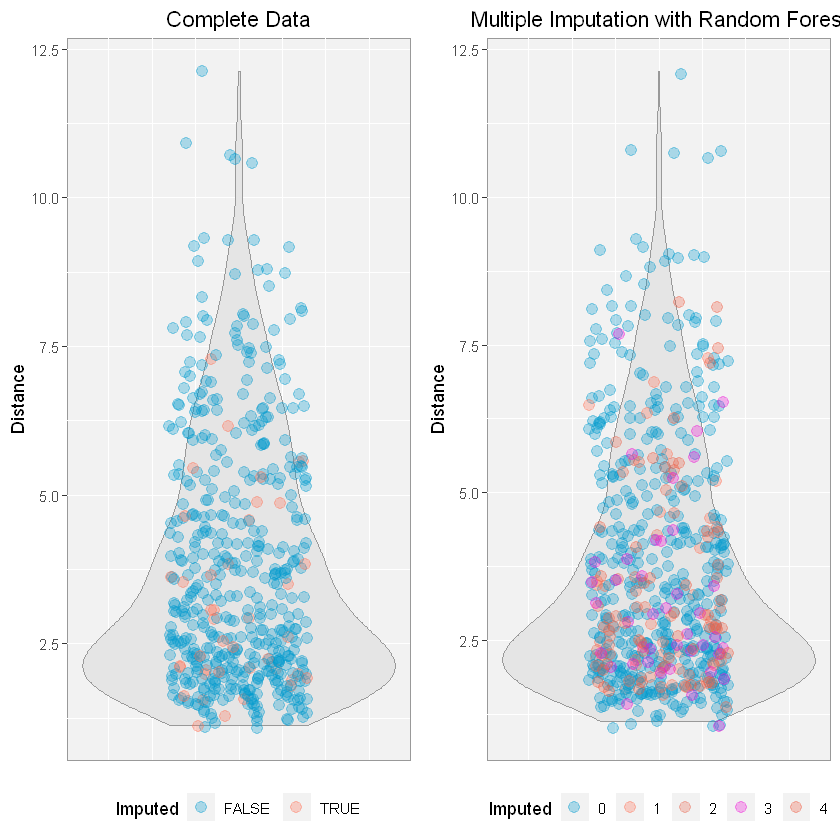

In [87]:
# Visualize imputation outcomes
plt_mi_imp <- plot_violin(mi_imp_df, ind_var, grp_var, "Multiple Imputation with Random Forest")
grid.arrange(df_plt, plt_mi_imp, ncol = 2)

In [72]:
# Compute basic statistics and compate to original data set
mi_stats <- df_stats
for (m in 1:mi_df$m){
  data <- mice::complete(data = mi_df, action = m) 
  stats_col <- paste0("MI_", as.character(m))
  stats <- get_stats(data[,ind_var], stats_col)
  mi_stats <- cbind(mi_stats, stats[stats_col])
}
mi_stats

Stats,Original,MI_1,MI_2,MI_3,MI_4
Min,1.13,1.13,1.13,1.13,1.13
Max,12.13,12.13,12.13,12.13,12.13
Mean,3.80,3.81,3.81,3.80,3.81
Median,3.21,3.17,3.22,3.21,3.21
StDev,2.11,2.11,2.09,2.10,2.12


### Comparison of the prepared datasets
Compare outcomes of different approaches to handle missing data.

#### Data distribution

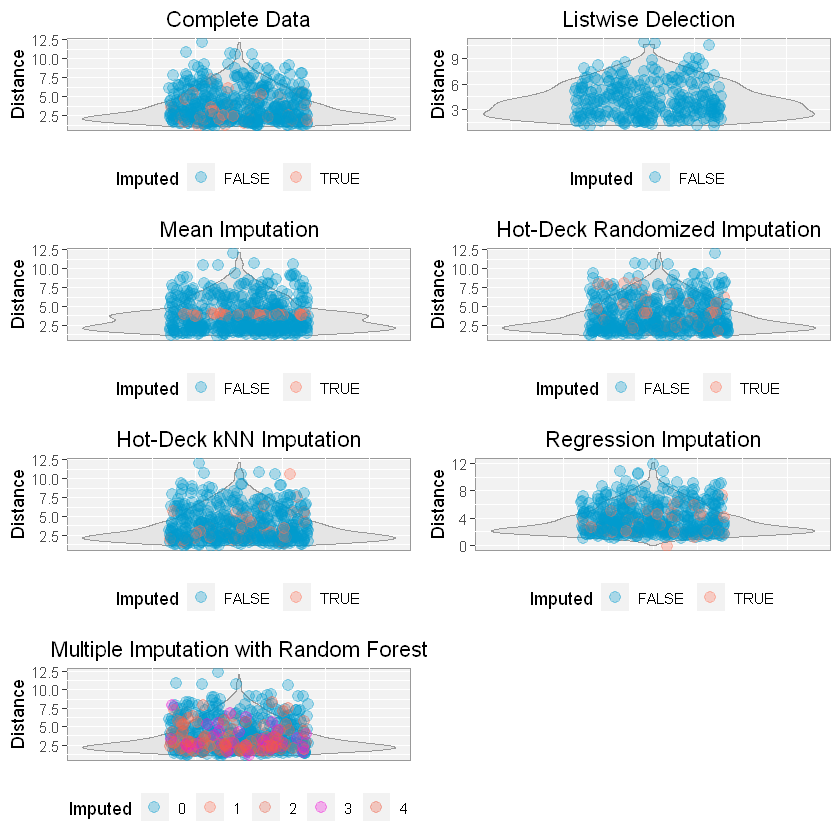

In [73]:
grid.arrange(df_plt, plt_lwd, plt_mean_imp, plt_hdr_imp, plt_knn_imp, plt_reg_imp, plt_mi_imp, ncol = 2)

#### Basic statistics

In [74]:
df_stats <- cbind(df_stats, lwd_stats["LWD"], mean_stats["Mean_Imp"], hdr_stats["HDR_Imp"], knn_stats["kNN_Imp"], 
                  reg_stats["Reg_Imp"], mi_stats[, 3:ncol(mi_stats)])
df_stats

Stats,Original,LWD,Mean_Imp,HDR_Imp,kNN_Imp,Reg_Imp,MI_1,MI_2,MI_3,MI_4
Min,1.13,1.13,1.13,1.13,1.13,-0.04,1.13,1.13,1.13,1.13
Max,12.13,10.71,12.13,12.13,12.13,12.13,12.13,12.13,12.13,12.13
Mean,3.80,4.15,3.85,3.86,3.82,3.81,3.81,3.81,3.80,3.81
Median,3.21,3.84,3.54,3.30,3.22,3.27,3.17,3.22,3.21,3.21
StDev,2.11,2.03,2.05,2.12,2.12,2.11,2.11,2.09,2.10,2.12
